In [2]:
from pyspark.sql import Row
from pyspark.sql import SparkSession
import random
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3.5"

# 初始化SparkSession
spark = SparkSession.builder \
    .master("spark://master:7077") \
    .appName("ＴｈｅoryGravityTide") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext

In [11]:
gravity_data = spark.read.text("hdfs://master:9000/dataset/GravityData/1/乌什_X212MPET0042_2015_1_12_原始观测数据.tsf")
gravity_data.persist()
gravity_fields = gravity_data.rdd.map(lambda row: row.value.split())
gravity_fields_preprocess = gravity_fields.filter(lambda row: len(row) > 3)\
                            .map(lambda row: Row(year=int(row[0]), month=int(row[1]), day=int(row[2]), hour=int(row[3]), \
                            minute=int(row[4]), second=int(row[5]), gravity=float(row[6]), air_pressure=float(row[7])))\

gravity_fields_preprocess.take(20)

[Row(air_pressure=877.91, day=12, gravity=-9394.24, hour=0, minute=0, month=1, second=0, year=2015),
 Row(air_pressure=878.59, day=12, gravity=-9384.68, hour=0, minute=0, month=1, second=1, year=2015),
 Row(air_pressure=877.91, day=12, gravity=-9379.11, hour=0, minute=0, month=1, second=2, year=2015),
 Row(air_pressure=879.15, day=12, gravity=-9377.85, hour=0, minute=0, month=1, second=3, year=2015),
 Row(air_pressure=879.04, day=12, gravity=-9402.51, hour=0, minute=0, month=1, second=4, year=2015),
 Row(air_pressure=878.7, day=12, gravity=-9400.18, hour=0, minute=0, month=1, second=5, year=2015),
 Row(air_pressure=878.7, day=12, gravity=-9403.42, hour=0, minute=0, month=1, second=6, year=2015),
 Row(air_pressure=879.15, day=12, gravity=-9390.99, hour=0, minute=0, month=1, second=7, year=2015),
 Row(air_pressure=878.59, day=12, gravity=-9371.15, hour=0, minute=0, month=1, second=8, year=2015),
 Row(air_pressure=878.47, day=12, gravity=-9372.37, hour=0, minute=0, month=1, second=9, year

In [5]:
def RULO(Y, M, D):
    ND = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    # l1 = Y - (Y / 4) * 4    #   Python类型自动转换了，而C++这里的（Y/4）自动转化为int了，所以这里有问题不能用C++的来
    l1 = Y - int(Y / 4) * 4
    if l1 == 0:
        ND[2] = 29
    K = 0
    for i in range(1, M):  #   for i in range(1, M):  这里原来的C++是小于等于，range（1：M）范围是1：M-1,所以下面 K = K - ND[M] 不需要了
        K = K + ND[i]
    # K = K - ND[M]
    # R = float(365 * (Y - 1900) + (Y - 1901)/4 + K + D) + 15019.5   # 这里(Y - 1901)/4 在c++里本意是取整，python里不是，这里需加int
    R = float(365 * (Y - 1900) + int( (Y - 1901) / 4 )+ K + D) + 15019.5 + 2400000  #  +2400000  是与我后写的程序对应的
    return R

In [112]:
def TheoryGravityTide(year, month, day, hour, miniute, second):    
    lat = 41.20
    lon = 79.21
    zone = 8
    delt = 1.16
# 此处显示有关此函数的摘要
# # 此处显示详细说明
    pi = 3.1415926535
    Deltath = delt #1.16
    tz = zone #8
    Year = year
    Month = month
    Day = day
    Phi = lat
    Phip = Phi - 0.192424 * math.sin(2 * Phi * pi / 180.0)
    Longtitude = lon * pi / 180.0
    Latitude = lat * pi / 180.0

    Phi = Latitude
    Phip = Phip * pi / 180.0
    dg = 0
    
    t = hour + miniute / 60.0 + second / 3600.0
    # T0 = Julian(Year(i), Month(i), Day(i))
    T0 = RULO(Year, Month, Day)
    # 2415020.0
    T = (T0 - 2415020.0 + (t - tz) / 24.0) / 36525.0
    S = 270.43416 + 481267.8831 * T - 0.001133 * T * T + 0.000002 * T * T * T
    h = 279.696678 + 36000.738925 * T + 0.0003025 * T * T
    p = 334.3295556 + 4069.034033 * T - 0.010325 * T * T - 0.0000125 * T * T * T
    N = 259.183275 - 1934.142008 * T + 0.002077 * T * T + 0.000002 * T * T * T
    ps = 281.2208333 + 1.719175 * T + 0.0004527 * T * T + 0.000003 * T * T * T
    e = 23.452294 - 0.0130125 * T - 0.00000163889 * T * T + 0.0000005027 * T * T * T

    S = S * pi / 180.0
    h = h * pi / 180.0
    p = p * pi / 180.0
    N = N * pi / 180.0
    ps = ps * pi / 180.0
    e = e * pi / 180.0
    # ** ** ** *求月亮的c / r及cosZ ** ** ** * #
    crm = 1 + 0.0545 * math.cos(S - p) + 0.0030 * math.cos(2 * (S - p)) + 0.01 * math.cos(S - 2 * h + p) + 0.0082 * math.cos(2 * (S - h))\
          +0.0006 * math.cos(2 * S - 3 * h + ps) + 0.0009 * math.cos(3 * S - 2 * h - p)
    Lambdam = S + 0.0222 * math.sin(S - 2 * h + p) + 0.1098 * math.sin(S - p) + 0.0115 * math.sin(2 * S - 2 * h) + 0.0037 * math.sin(2 * S - 2 * p)\
                  -0.0032 * math.sin(h - ps) - 0.001 * math.sin(2 * h - 2 * p) + 0.001 * math.sin(S - 3 * h + p + ps) + 0.0007 * math.sin(S - h - p + ps)\
                  -0.0006 * math.sin(S - h) - 0.0005 * math.sin(S + h - p - ps) + 0.0008 * math.sin(2 * S - 3 * h + ps) - 0.002 * math.sin(2 * S - 2 * N) \
                  +0.0009 * math.sin(3 * S - 2 * h - p)
    Beltam = 0.003 * math.sin(S - 2 * h + N) + 0.0895 * math.sin(S - N) + 0.0049 * math.sin(2 * S - p - N) - 0.0048 * math.sin(p - N) - 0.0008 * \
                 math.sin(2 * h - p - N)+0.001 * math.sin(2 * S - 2 * h + p - N) + 0.0006 * math.sin(3 * S - 2 * h - N)
    Delta = math.sin(e) * math.sin(Lambdam) * math.cos(Beltam) + math.cos(e) * math.sin(Beltam)
    Theta = ((t - tz) * (15 * pi / 180.0)) + h + Longtitude - pi
    H = math.cos(Beltam) * math.cos(Lambdam) * math.cos(Theta) + math.sin(Theta) * (math.cos(e) * math.cos(Beltam) * math.sin(Lambdam) - math.sin(e) * math.sin(Beltam))
    Zm = math.sin(Phip) * Delta + math.cos(Phip) * H # # Zm = cos(Zm)
    # # ** ** ** *求太阳的c / r及cosZ ** ** ** * # #
    crs = 1 + 0.0168 * math.cos(h - ps) + 0.0003 * math.cos(2 * h - 2 * ps)
    Lambdas = h + 0.0335 * math.sin(h - ps) + 0.0004 * math.sin(2 * h - 2 * ps)
    Beltas = 0.0
    Zs = math.sin(Phip) * math.sin(e) * math.sin(Lambdas) + math.cos(Phip) * (math.cos(Lambdas) * math.cos(Theta) + math.sin(Theta) * math.cos(e) * math.sin(Lambdas))
    # # Zs = cos(Zs)

    F = 0.998327 + 0.001676 * math.cos(2 * Phi)
    Gt = -165.17 * F * crm * crm * crm * (Zm * Zm - 1.0 / 3.0) - 1.3708 * F * F * crm * crm * crm * crm * Zm * (
                    5 * Zm * Zm - 3) - 76.08 * F * crs * crs * crs * (Zs * Zs - 1.0 / 3.0)
    dg = Deltath * Gt
    
    return float(dg)

## 两种方法对同一ＤａｔａＦｒａｍｅ的不同列进行处理，计算理论潮汐值
* 先转换成ＲＤＤ，然后利用ＲＤＤ的ｍａｐ函数，这种方法只能生成新的ＤａｔａＦｒａｍｅ
* 直接利用ＤａｔａＦｒａｍｅ的自定义函数，可以直接在原ＤａｔａＦｒａｍｅ上新增一列

In [100]:
import numpy as np
import pandas as np
import math

gravity_jion = gravity_fields_preprocess.map(lambda row: \
        Row(theory_gravity_tide = TheoryGravityTide(row["year"], row["month"], row["day"],\
                          row["hour"], row["minute"], row["second"]),\
            diff = row["gravity"] - TheoryGravityTide(row["year"], row["month"], row["day"],\
                          row["hour"], row["minute"], row["second"]),\
           gravity = row["gravity"])).toDF()
gravity_jion.show(5)

+------------------+--------+-------------------+
|              diff| gravity|theory_gravity_tide|
+------------------+--------+-------------------+
|-9411.619168095503|-9394.24|  17.37916809550363|
|-9402.059228199163|-9384.68| 17.379228199162043|
|-9396.489287831713|-9379.11|  17.37928783171344|
|-9395.229346993101|-9377.85|  17.37934699310132|
|-9419.889405683385|-9402.51|  17.37940568338452|
+------------------+--------+-------------------+
only showing top 5 rows



In [117]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType 

gravity_fields_df = gravity_fields_preprocess.toDF()
theory_gravity_tide_udf = udf(TheoryGravityTide, FloatType())
gravity_fields_df.withColumn("theory_gravity_tide", theory_gravity_tide_udf("year", "month", "day", "hour", "minute", "second"))\
            .withColumn("diff", gravity_fields_df["gravity"] - theory_gravity_tide_udf("year", "month", "day", "hour", "minute", "second")).show(5)

+------------+---+--------+----+------+-----+------+----+-------------------+------------------+
|air_pressure|day| gravity|hour|minute|month|second|year|theory_gravity_tide|              diff|
+------------+---+--------+----+------+-----+------+----+-------------------+------------------+
|      877.91| 12|-9394.24|   0|     0|    1|     0|2015|          17.379168|-9411.619167556762|
|      878.59| 12|-9384.68|   0|     0|    1|     1|2015|          17.379229| -9402.05922859192|
|      877.91| 12|-9379.11|   0|     0|    1|     2|2015|          17.379288|-9396.489287719727|
|      879.15| 12|-9377.85|   0|     0|    1|     3|2015|          17.379347|-9395.229346847535|
|      879.04| 12|-9402.51|   0|     0|    1|     4|2015|          17.379406|-9419.889405975342|
+------------+---+--------+----+------+-----+------+----+-------------------+------------------+
only showing top 5 rows



In [28]:
import matplotlib.pyplot as plt
# 画减去潮汐值
def drawPicture2(picname,gravitySubTide):
    # f['Time'] = f['Year'].map(str)+f['Month'].map(str)+f['Day'].map(str)+f['Hour'].map(str)+f['Minute'].map(str)+f['Second'].map(str)
    #fig = plt.figure()
    fig = plt.figure(figsize=(40,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(picname)
    ax.set_xlabel('Time')
    ax.set_ylabel('Gravity Sub Tide')
    ax.plot(gravitySubTide)
    plt.show()

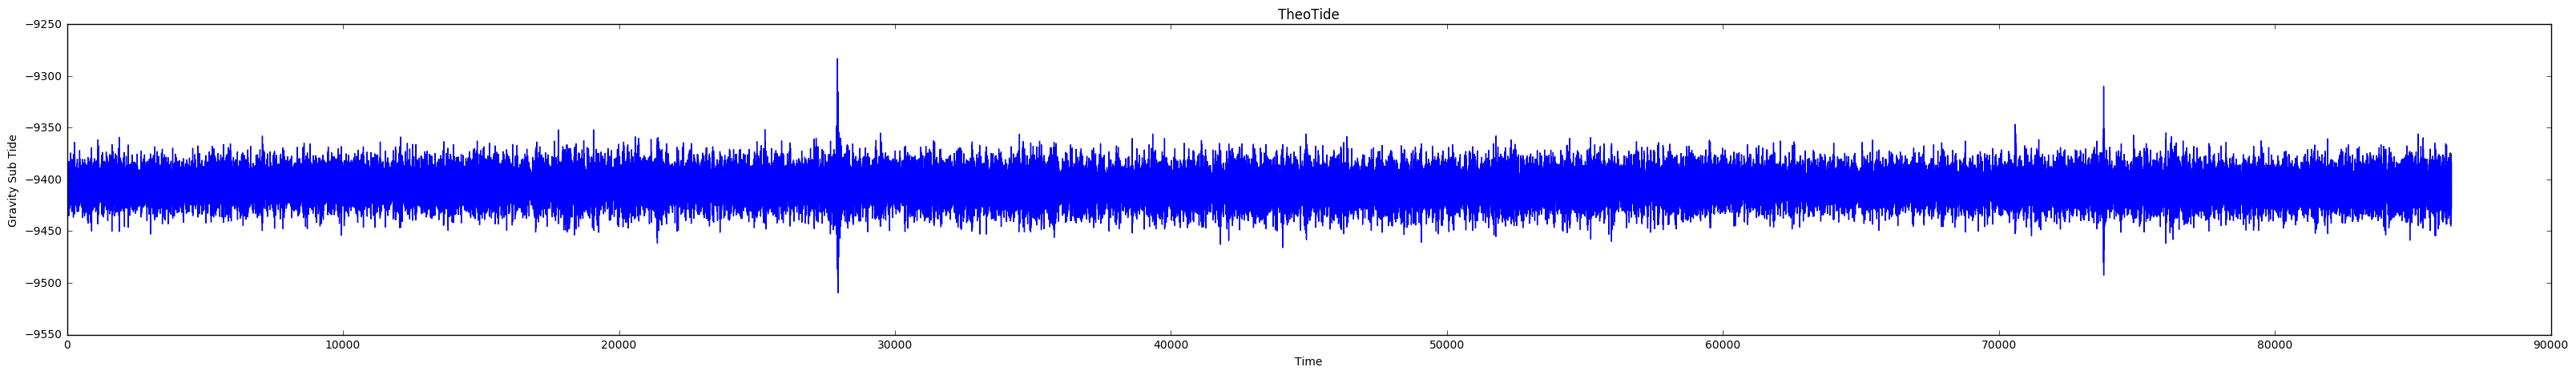

In [44]:
diff = gravity_jion.select("diff").collect()
drawPicture2('TheoTide',diff)

In [72]:
from pyspark.sql import Window
from pyspark.sql.functions import avg, stddev, mean

diff_df = gravity_jion.select("diff")
wSpec = Window.rowsBetween(-1799, 1800)
gravity_window_feature = diff_df.withColumn("movingAvg", avg(diff_df["diff"]).over(wSpec))\
        .withColumn("movingStd", stddev(diff_df["diff"]).over(wSpec))
#gravity_mean = gravity_jion.select(mean(gravity_jion.diff).alias('avg')).rdd.map(lambda row: row["avg"]).collect()
gravity_window_feature.show(5)

+------------------+------------------+------------------+
|              diff|         movingAvg|         movingStd|
+------------------+------------------+------------------+
|-9411.619168095503|-9405.848898683515|12.694626354935544|
|-9402.059228199163|-9405.855876221627|12.694557514923563|
|-9396.489287831713|-9405.855086283556|12.691078999403198|
|-9395.229346993101|-9405.860300100985|12.689491521756375|
|-9419.889405683385| -9405.85696475881|  12.6867653812661|
+------------------+------------------+------------------+
only showing top 5 rows



In [84]:
gravity_window_feature.rdd.map(lambda row:  row["diff"] - row["movingAvg"] > 3 * row["movingStd"]).take(10)

[False, False, False, False, False, False, False, False, False, False]

In [126]:
wSpec = Window.rowsBetween(-299, 300)
wSpec0 = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
diff_df.withColumn("movingAvg_600", avg(diff_df["diff"]).over(wSpec)).show(20)

AttributeError: 'NoneType' object has no attribute '_jvm'

In [125]:
spark.stop()